In [72]:
!pip install transformers
!pip install librosa numpy matplotlib tensorflow scikit-learn

In [73]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [74]:
DATA_DIR = "Audio_Speech_Actors_01-24/"
SR = 22050
DURATION = 3
N_MELS = 64
DATA_PATH = "/content/"
EMOTION_MAP = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [75]:
def augment_audio(y, sr):

    y = librosa.effects.time_stretch(y, rate=np.random.uniform(0.9, 1.1))

    y = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.uniform(-1.5, 1.5))

    y = np.tanh(y * np.random.uniform(1, 3))

    noise = np.random.normal(0, 0.002 * np.max(y), len(y))
    return y + noise

In [76]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=SR, duration=DURATION)

    if len(y) < SR * DURATION:
        y = np.pad(y, (0, SR * DURATION - len(y)))
    y = y[:SR * DURATION]

    S = librosa.feature.melspectrogram(y=y, sr=SR, n_mels=N_MELS,
                                     fmax=8000, hop_length=512)
    S = librosa.power_to_db(S, ref=np.max)


    S = (S - S.min()) / (S.max() - S.min() + 1e-8) * 2 - 1
    return S


In [77]:
def load_data():
    X, y = [], []

    for file in os.listdir(DATA_DIR):
        if file.endswith('.wav'):
            parts = file.split('-')
            emotion_code = int(parts[2])
            if 1 <= emotion_code <= 8:
                X.append(extract_features(os.path.join(DATA_DIR, file)))
                y.append(emotion_code - 1)


    X = np.array(X)[..., np.newaxis]
    y = utils.to_categorical(y, num_classes=8)
    return X, y

In [101]:
from tensorflow.keras import regularizers

def build_emotion_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # --- Branch 1: Spectral Features ---
    x1 = layers.Conv2D(64, (3,3), padding='same', activation='relu')(inputs)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.MaxPooling2D((2,2))(x1)

    x1 = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Permute((2, 1, 3))(x1) # Permute to match temporal branch dimensions

    # --- Branch 2: Temporal Features ---
    x2 = layers.Permute((2, 1, 3))(inputs)  # Swap time and frequency axes
    x2 = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.MaxPooling2D((2,2))(x2)


    x = layers.Concatenate()([x1, x2])
    x = layers.Conv2D(256, (3,3), activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)

    # --- Attention Mechanism ---
    attention = layers.Dense(256, activation='tanh')(x)
    attention = layers.Dense(1, activation='softmax')(attention)
    x = layers.Multiply()([x, attention])

    # --- Classifier ---
    x = layers.Dense(128, activation='relu',
                    kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)

model = build_emotion_model((N_MELS, 130, 1), 8)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 64, 130,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 64, 130,   │        640 │ input_layer_9[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 130,   │        256 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 32, 65,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_6 (Permute) │ (None, 130, 64,   │          0 │ input_layer_9[0]… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 32, 65,    │     73,856 │ max_pooling2d_24… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 130, 64,   │        640 │ permute_6[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 65,    │        512 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 130, 64,   │        256 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_5 (Permute) │ (None, 65, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 65, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 65, 32,    │          0 │ permute_5[0][0],  │
│ (Concatenate)       │ 192)              │            │ max_pooling2d_25… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 63, 30,    │    442,624 │ concatenate_4[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ conv2d_30[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 256)       │     65,792 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │        257 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 256)       │          0 │ global_average_p… │
│ (Multiply)          │                   │            │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 618,761 (2.36 MB)

 Trainable params: 618,249 (2.36 MB)

 Non-trainable params: 512 (2.00 KB)

In [79]:
!unzip Audio_Speech_Actors_01-24.zip

Archive:  Audio_Speech_Actors_01-24.zip
replace Actor_01/03-01-01-01-01-01-01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [102]:
X, y = load_dataset()
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, stratify=np.argmax(y, axis=1), random_state=42)

In [103]:
class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(np.argmax(y_train, axis=1)),
        y=np.argmax(y_train, axis=1)
    )
class_weights = dict(enumerate(class_weights))

In [104]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=15),
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
    ]

In [105]:
history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_test, y_test),
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

Epoch 1/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1462 - loss: 3.7725

36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.1473 - loss: 3.7672 - val_accuracy: 0.1319 - val_loss: 3.5823 - learning_rate: 3.0000e-04
Epoch 2/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2447 - loss: 3.4105

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.2453 - loss: 3.4073 - val_accuracy: 0.1285 - val_loss: 3.4555 - learning_rate: 3.0000e-04
Epoch 3/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2878 - loss: 3.1412

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.2884 - loss: 3.1385 - val_accuracy: 0.1319 - val_loss: 3.4045 - learning_rate: 3.0000e-04
Epoch 4/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3201 - loss: 2.9463

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.3211 - loss: 2.9443 - val_accuracy: 0.1493 - val_loss: 3.3960 - learning_rate: 3.0000e-04
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.3197 - loss: 2.7616 - val_accuracy: 0.1319 - val_loss: 3.4606 - learning_rate: 3.0000e-04
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.3639 - loss: 2.6295 - val_accuracy: 0.1319 - val_loss: 3.4889 - learning_rate: 3.0000e-04
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.3678 - loss: 2.5516 - val_accuracy: 0.1319 - val_loss: 3.4613 - learning_rate: 3.0000e-04
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.3997 - loss: 2.4355 - val_accuracy: 0.1319 - val_loss: 3.4271 - learning_rate: 3.0000e-04
Epoch 9/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4296 - loss: 2.3470

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.4285 - loss: 2.3459 - val_accuracy: 0.1667 - val_loss: 3.3783 - learning_rate: 3.0000e-04
Epoch 10/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4158 - loss: 2.2397

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4155 - loss: 2.2403 - val_accuracy: 0.1458 - val_loss: 3.3165 - learning_rate: 3.0000e-04
Epoch 11/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4091 - loss: 2.2038

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.4097 - loss: 2.2023 - val_accuracy: 0.1597 - val_loss: 3.3017 - learning_rate: 3.0000e-04
Epoch 12/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3959 - loss: 2.1473

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.3975 - loss: 2.1453 - val_accuracy: 0.1875 - val_loss: 3.1870 - learning_rate: 3.0000e-04
Epoch 13/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4670 - loss: 2.0097

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.4660 - loss: 2.0111 - val_accuracy: 0.2292 - val_loss: 3.0042 - learning_rate: 3.0000e-04
Epoch 14/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.4488 - loss: 2.0140 - val_accuracy: 0.2188 - val_loss: 3.1057 - learning_rate: 3.0000e-04
Epoch 15/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4790 - loss: 1.9766

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.4789 - loss: 1.9748 - val_accuracy: 0.2361 - val_loss: 2.9302 - learning_rate: 3.0000e-04
Epoch 16/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4544 - loss: 1.8879

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4545 - loss: 1.8895 - val_accuracy: 0.2396 - val_loss: 2.8891 - learning_rate: 3.0000e-04
Epoch 17/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4993 - loss: 1.8888

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4981 - loss: 1.8898 - val_accuracy: 0.2535 - val_loss: 2.6837 - learning_rate: 3.0000e-04
Epoch 18/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4996 - loss: 1.8469

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.4996 - loss: 1.8448 - val_accuracy: 0.2465 - val_loss: 2.4887 - learning_rate: 3.0000e-04
Epoch 19/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5111 - loss: 1.7557 - val_accuracy: 0.2639 - val_loss: 2.5149 - learning_rate: 3.0000e-04
Epoch 20/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5592 - loss: 1.7310

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5576 - loss: 1.7311 - val_accuracy: 0.3646 - val_loss: 2.1440 - learning_rate: 3.0000e-04
Epoch 21/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.4884 - loss: 1.8035 - val_accuracy: 0.3889 - val_loss: 2.2929 - learning_rate: 3.0000e-04
Epoch 22/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.5273 - loss: 1.7300 - val_accuracy: 0.3194 - val_loss: 2.1582 - learning_rate: 3.0000e-04
Epoch 23/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4989 - loss: 1.7142

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4992 - loss: 1.7129 - val_accuracy: 0.4097 - val_loss: 1.9631 - learning_rate: 3.0000e-04
Epoch 24/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5259 - loss: 1.6542

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.5257 - loss: 1.6545 - val_accuracy: 0.4653 - val_loss: 1.7753 - learning_rate: 3.0000e-04
Epoch 25/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5394 - loss: 1.6271 - val_accuracy: 0.3403 - val_loss: 2.1325 - learning_rate: 3.0000e-04
Epoch 26/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5571 - loss: 1.6074 - val_accuracy: 0.4306 - val_loss: 1.9288 - learning_rate: 3.0000e-04
Epoch 27/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5446 - loss: 1.5950 - val_accuracy: 0.3958 - val_loss: 2.2575 - learning_rate: 3.0000e-04
Epoch 28/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5060 - loss: 1.6382 - val_accuracy: 0.3993 - val_loss: 1.9605 - learning_rate: 3.0000e-04
Epoch 29/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5445 - loss: 1.5438

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5447 - loss: 1.5439 - val_accuracy: 0.4931 - val_loss: 1.7349 - learning_rate: 3.0000e-04
Epoch 30/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5432 - loss: 1.5286 - val_accuracy: 0.3542 - val_loss: 2.2162 - learning_rate: 3.0000e-04
Epoch 31/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.5541 - loss: 1.5035 - val_accuracy: 0.3403 - val_loss: 2.0790 - learning_rate: 3.0000e-04
Epoch 32/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5873 - loss: 1.4973

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5873 - loss: 1.4958 - val_accuracy: 0.4479 - val_loss: 1.7021 - learning_rate: 3.0000e-04
Epoch 33/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.5768 - loss: 1.4355 - val_accuracy: 0.5104 - val_loss: 1.7377 - learning_rate: 3.0000e-04
Epoch 34/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5777 - loss: 1.4307

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.5769 - loss: 1.4311 - val_accuracy: 0.5069 - val_loss: 1.5950 - learning_rate: 3.0000e-04
Epoch 35/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5888 - loss: 1.4503

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.5892 - loss: 1.4492 - val_accuracy: 0.5243 - val_loss: 1.5334 - learning_rate: 3.0000e-04
Epoch 36/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5588 - loss: 1.4567 - val_accuracy: 0.5243 - val_loss: 1.6399 - learning_rate: 3.0000e-04
Epoch 37/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6009 - loss: 1.3887 - val_accuracy: 0.4896 - val_loss: 1.6566 - learning_rate: 3.0000e-04
Epoch 38/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6177 - loss: 1.3402 - val_accuracy: 0.4931 - val_loss: 1.5538 - learning_rate: 3.0000e-04
Epoch 39/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.5971 - loss: 1.3855 - val_accuracy: 0.5382 - val_loss: 1.5601 - learning_rate: 3.0000e-04
Epoch 40/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6120 - loss: 1.3505 - val_accuracy: 0.4201 - val_loss: 2.0637 - learning_rate: 3.0000e-04
Epoch 41/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5892

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.5896 - loss: 1.3618 - val_accuracy: 0.6007 - val_loss: 1.4573 - learning_rate: 3.0000e-04
Epoch 42/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6361 - loss: 1.2298 - val_accuracy: 0.4549 - val_loss: 1.6858 - learning_rate: 3.0000e-04
Epoch 43/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6088 - loss: 1.3170

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6085 - loss: 1.3170 - val_accuracy: 0.5556 - val_loss: 1.4131 - learning_rate: 3.0000e-04
Epoch 44/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6372 - loss: 1.2652 - val_accuracy: 0.4792 - val_loss: 1.5841 - learning_rate: 3.0000e-04
Epoch 45/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6334 - loss: 1.2552 - val_accuracy: 0.5347 - val_loss: 1.5091 - learning_rate: 3.0000e-04
Epoch 46/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6359 - loss: 1.2094 - val_accuracy: 0.5312 - val_loss: 1.4234 - learning_rate: 3.0000e-04
Epoch 47/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6324 - loss: 1.2698 - val_accuracy: 0.5833 - val_loss: 1.4340 - learning_rate: 3.0000e-04
Epoch 48/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6280 - loss: 1.2041

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6288 - loss: 1.2048 - val_accuracy: 0.5799 - val_loss: 1.4051 - learning_rate: 3.0000e-04
Epoch 49/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6885 - loss: 1.1357 - val_accuracy: 0.5208 - val_loss: 1.4988 - learning_rate: 3.0000e-04
Epoch 50/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6473 - loss: 1.1843 - val_accuracy: 0.5069 - val_loss: 1.5632 - learning_rate: 3.0000e-04
Epoch 51/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6547 - loss: 1.1786 - val_accuracy: 0.5382 - val_loss: 1.5279 - learning_rate: 3.0000e-04
Epoch 52/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6434 - loss: 1.1943

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6435 - loss: 1.1942 - val_accuracy: 0.5972 - val_loss: 1.3294 - learning_rate: 3.0000e-04
Epoch 53/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6867 - loss: 1.1359 - val_accuracy: 0.4653 - val_loss: 1.7381 - learning_rate: 3.0000e-04
Epoch 54/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.6610 - loss: 1.1618 - val_accuracy: 0.5521 - val_loss: 1.3929 - learning_rate: 3.0000e-04
Epoch 55/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6706 - loss: 1.1293

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6704 - loss: 1.1300 - val_accuracy: 0.6389 - val_loss: 1.2910 - learning_rate: 3.0000e-04
Epoch 56/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6873 - loss: 1.1069

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.6860 - loss: 1.1078 - val_accuracy: 0.6181 - val_loss: 1.2634 - learning_rate: 3.0000e-04
Epoch 57/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6673 - loss: 1.1161 - val_accuracy: 0.6007 - val_loss: 1.2918 - learning_rate: 3.0000e-04
Epoch 58/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.6851 - loss: 1.1237 - val_accuracy: 0.4271 - val_loss: 2.1134 - learning_rate: 3.0000e-04
Epoch 59/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7101 - loss: 1.0686 - val_accuracy: 0.5694 - val_loss: 1.3377 - learning_rate: 3.0000e-04
Epoch 60/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6832 - loss: 1.0605

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6840 - loss: 1.0594 - val_accuracy: 0.6389 - val_loss: 1.2214 - learning_rate: 3.0000e-04
Epoch 61/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7203 - loss: 1.0000 - val_accuracy: 0.5764 - val_loss: 1.3535 - learning_rate: 3.0000e-04
Epoch 62/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6717 - loss: 1.0664 - val_accuracy: 0.5625 - val_loss: 1.3244 - learning_rate: 3.0000e-04
Epoch 63/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.6973 - loss: 1.0100 - val_accuracy: 0.6215 - val_loss: 1.2243 - learning_rate: 3.0000e-04
Epoch 64/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6818 - loss: 1.0269 - val_accuracy: 0.5174 - val_loss: 1.4719 - learning_rate: 3.0000e-04
Epoch 65/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7020 - loss: 1.0315 - val_accuracy: 0.5764 - val_loss: 1.4789 - learning_rate: 3.0000e-04
Epoch 66/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7283

In [108]:
model = models.load_model('best_model.h5')
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.2%}")
print(f"Test Loss: {test_loss:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6415 - loss: 1.1991

Test Accuracy: 63.89%
Test Loss: 1.2214


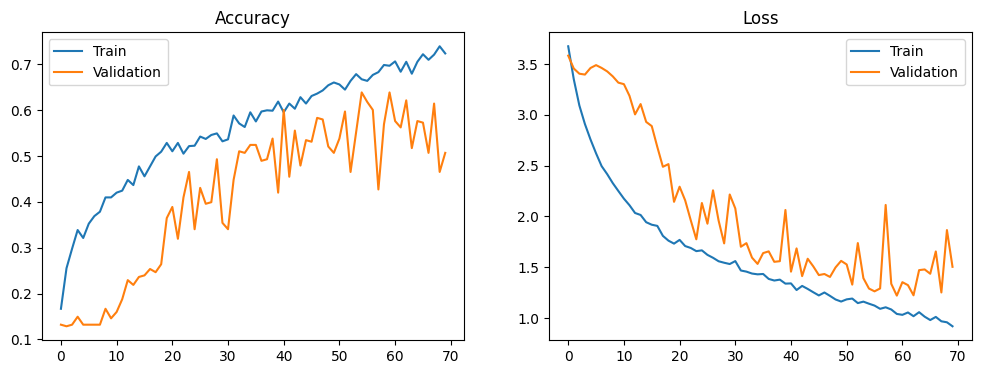

In [109]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.show()

In [116]:
from IPython.display import Audio
Audio("/content/Actor_03/03-01-07-01-01-02-03.wav", rate=SR)

In [115]:
audio_path = "/content/Actor_03/03-01-07-01-01-02-03.wav"
features = extract_features(audio_path)
features = np.expand_dims(features, axis=0)
features = np.expand_dims(features, axis=-1)

prediction = model.predict(features)
predicted_class_index = np.argmax(prediction)
predicted_emotion = list(EMOTION_MAP.values())[predicted_class_index]

print(f"Predicted emotion: {predicted_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted emotion: disgust
